In [1]:
import os
import psutil
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('/home/ci411/pcen-t-varying/scripts/core_scripts')
m = __import__ ('02_train')
try:
    attrlist = m.__all__
except AttributeError:
    attrlist = dir (m)
for attr in attrlist:
    globals()[attr] = getattr (m, attr)

Using TensorFlow backend.


In [2]:
params = process_arguments('')

In [8]:
#make or clear output directory
make_dirs(os.path.join(params.model_dir, params.modelid))

#get feature paths
train_features = []
valid_features = []
test_features = []
for feature_name in ast.literal_eval(params.feature_names):
    train_features.append(os.path.join(params.feature_dir, feature_name, 'train'))
    valid_features.append(os.path.join(params.feature_dir, feature_name, 'validate'))
pump = load_pump(os.path.join(params.load_pump, 'pump.pkl'))
sampler = make_sampler(params.max_samples, params.duration, pump, params.seed)

if params.slices is not None:
    slices = ast.literal_eval(params.slices)
else:
    #extracting number of slices from pump and making an array if no subslices provided
    slices = np.arange(pump['dynamic'].__dict__['fields']['dynamic/tags'].shape[1])

construct_model = MODELS[params.modelname]

input_layer = Input(name='PCEN/mag',  shape=(None, params.n_mels, len(slices)),\
                          dtype='float32')    
model, inputs, outputs = construct_model(input_layer, pump)    

gen_train = data_generator(train_features, sampler, params.train_streamers,\
                       params.rate, random_state=params.seed, slices=slices)

#memory leak test
gen_val = data_generator(train_features, sampler, params.train_streamers,\
                       params.rate, random_state=params.seed, slices=slices)

#gen_val = data_generator_val(train_features, sampler, random_state=params.seed, slices=slices)

output_vars = 'dynamic/tags'

#create data generators
gen_train = keras_tuples(gen_train(), inputs=inputs, outputs=output_vars)

gen_val = keras_tuples(gen_val(), inputs=inputs, outputs=output_vars)

#val_data = draw_validation_data(valid_features, sampler, params.validation_size, slices=slices)

#print("Val Data Shape: {},{}".format(val_data[0].shape, val_data[1].shape))

loss = {output_vars: 'binary_crossentropy'}
metrics = {output_vars: 'accuracy'}
monitor = 'val_{}_acc'.format(output_vars)

gen_train_label = label_transformer_generator(gen_train)
gen_val_label = label_transformer_generator(gen_val)


100%|██████████| 6000/6000 [00:00<00:00, 138701.29it/s]


In [9]:
process = psutil.Process(os.getpid())
train_memory = []
while(len(train_memory)<1e4):
    gen_train_label.__next__()
    train_memory.append(process.memory_info().rss)
    sys.stdout.write("Memory Utilization: {:.2f}Mb\r".format(process.memory_info().rss*1e-6))
    sys.stdout.flush()
    

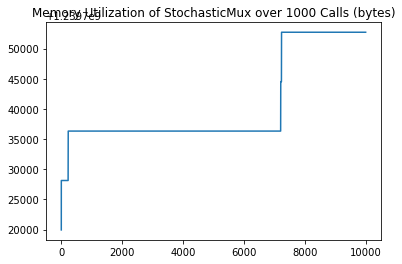

In [10]:
plt.plot(np.arange(len(train_memory)), train_memory)
plt.title("Memory Utilization of StochasticMux over 1000 Calls (bytes)")

In [11]:
process = psutil.Process(os.getpid())
val_memory = []
while(len(val_memory)<1e4):
    gen_val_label.__next__()
    val_memory.append(process.memory_info().rss)
    sys.stdout.write("Memory Utilization: {:.2f}Mb\r".format(process.memory_info().rss*1e-6))
    sys.stdout.flush()
    

KeyboardInterrupt: 

In [ ]:
plt.plot(np.arange(len(val_memory)), val_memory)
plt.title("Memory Utilization of RoundRobinMux over 1000 Calls (bytes)")

In [13]:
@pescador.streamable
def data_sampler(fname, sampler, slices):
    '''Generate samples from a specified h5 file'''
    data_dict = load_h5(fname)
    if slices is not None:
        data = data_dict['PCEN/mag']
        data_sliced = data[:,:,:,slices]
        data_dict['PCEN/mag'] = data_sliced
    file_sampler = sampler(data_dict)
    for datum in file_sampler:
        yield datum